# Agent

In this notebook, **we're going to build a simple agent using using LangGraph**.

This notebook is part of the <a href="https://www.hf.co/learn/agents-course">Hugging Face Agents Course</a>, a free course from beginner to expert, where you learn to build Agents.

![Agents course share](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/communication/share.png)

As seen in the Unit 1, an agent needs 3 steps as introduced in the ReAct architecture :
[ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)


![Agent](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Agent.png)

In [20]:
# restart the kernel if you use pip to install new packages.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:

import os

# Please setp your own key.
os.environ["OPENAI_API_KEY"]=""

In [34]:
import base64
from typing import List
from langchain.schema import HumanMessage
from langchain_openai import ChatOpenAI

vision_llm = ChatOpenAI(model="gpt-4o")

def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.

    Master Wayne often leaves notes with his training regimen or meal plans.
    This allows me to properly analyze the contents.
    """
    all_text = ""
    try:
        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # A butler should handle errors gracefully
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""


llm = ChatOpenAI(model="gpt-3.5-turbo")

def multiply(a: float, b: float) -> float:
    """Divide a and b."""
    return a * b

def divide(a: float, b: float) -> float:
    """Divide a and b."""
    return a / b

def count_occurrences(text: str, phrase: str) -> int:
    """Count the number of occurrences of a phrase in a text."""
    return text.count(phrase)

def bigram_condition_prob_in_corpus(corpus: str, preword: str, word: str) -> float:
    """Count the conditional probability of a word given a preword in a corpus."""
    raise NotImplementedError("Not implemented yet")

def bigram_prob(text: str, phrase: str) -> float:
    """Count the bigram prob without smooth."""
    raise NotImplementedError("Not implemented yet")

def bigram_prob_smooth(text: str, phrase: str) -> float:
    """Count the bigram prob with smooth."""
    raise NotImplementedError("Not implemented yet")

tools = [
    extract_text,
    count_occurrences,
    # bigram_prob,
    # bigram_condition_prob_in_corpus,
    # bigram_prob_smooth,
    divide,
    multiply
]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [23]:
from typing import TypedDict, Annotated, List, Any, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
class AgentState(TypedDict):
    # The input document
    input_file:  Optional[str]  # Contains file path, type (PNG)
    messages: Annotated[list[AnyMessage], add_messages]

In [25]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.utils.function_calling import convert_to_openai_tool


# AgentState
def assistant(state: AgentState):
    # System message
    textual_description_of_tool="""
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
"""
    image=state["input_file"]
    sys_msg = SystemMessage(content=f"You are an helpful agent that can analyse some images and run some ngram analysis and computing without provided tools :\n{textual_description_of_tool} \n You have access to some otpional images. Currently the loaded images is : {image}")


    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],"input_file":state["input_file"]}

We define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

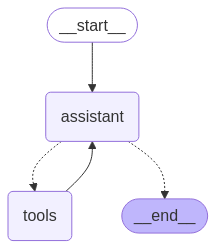

In [26]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [27]:
messages = [HumanMessage(content="Multipy 6790 by 5")]

messages = react_graph.invoke({"messages": messages,"input_file":None})

In [28]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multipy 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_E6P0TxuEIFouK4n6dxIW8OWH)
 Call ID: call_E6P0TxuEIFouK4n6dxIW8OWH
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: multiply

33950.0
================================== Ai Message ==================================

The result of multiplying 6790 by 5 is 33950.


In [37]:
messages = [HumanMessage(content="According to the screenshot of the exam, solve the ngram questions steps by steps")]
messages = react_graph.invoke({"messages": messages, "input_file": "../data/nlp-exam-q3-q4.png"})

In [38]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According to the screenshot of the exam, solve the ngram questions steps by steps
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_DrDTR44C4jy6P0yJg5nWxGR6)
 Call ID: call_DrDTR44C4jy6P0yJg5nWxGR6
  Args:
    img_path: ../data/nlp-exam-q3-q4.png
================================= Tool Message =================================
Name: extract_text

N-Gram Language Models (15’)

```
<s> some are fast </s>
<s> and some are slow </s>
<s> some are high </s>
<s> and some are low </s>
```

Treat <s> and </s> as regular tokens (i.e., include them in the vocabulary and counts).

3. (5’) Using the corpus given above, what is the conditional probability of seeing "some" having just seen the word "and" (i.e., P(some | and).) Assume a bigram approach and no smoothing.

4. (10’) Given the earlier corpus, and a bigram language model (with add-1 smoothing) wha